In [ ]:
!pip install nlp

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import nlp


#importing the data

In [ ]:
dataset = nlp.load_dataset('emotion')

In [5]:
dataset

{'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [6]:
train = dataset['train']
test = dataset['test']
val = dataset['validation']

In [7]:
def get_tweet(data):
  tweets = [x['text'] for x in data]
  labels = [x['label'] for x in data]
  return tweets , labels

In [8]:
tweets , labels = get_tweet(train)

In [9]:
tweets[0] , labels[0]

('i didnt feel humiliated', 'sadness')

#Tokenizer

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words = 10000 , oov_token = '<UNK>')
tokenizer.fit_on_texts(tweets)

In [11]:
tokenizer.texts_to_sequences([tweets[0]])

[[2, 139, 3, 679]]

In [12]:
tweets[0]

'i didnt feel humiliated'

#padding and truncating

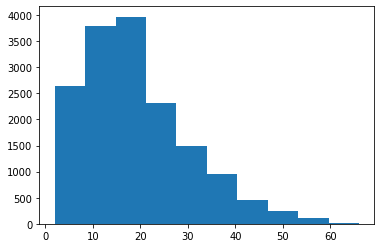

In [13]:
lengths = [len(tweet.split(' ')) for tweet in tweets]
plt.hist(lengths)
plt.show()

In [14]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
maxlen = 50

def get_sequences(tokenizer , tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences , truncating = 'post' ,
                         padding = 'post' ,
                         maxlen = maxlen)
  return padded

In [15]:
padded_train_seq = get_sequences(tokenizer , tweets)

In [16]:
print('the tweet is : ' , tweets[0])
print()
print('after tokenizing and make it seq : ' ,tokenizer.texts_to_sequences([tweets[0]]))
print()
print('after padding : ' ,padded_train_seq[0])

the tweet is :  i didnt feel humiliated

after tokenizing and make it seq :  [[2, 139, 3, 679]]

after padding :  [  2 139   3 679   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


#preparing the classes

In [17]:
classes = set(labels)
print(classes)

{'surprise', 'joy', 'sadness', 'anger', 'fear', 'love'}


<function matplotlib.pyplot.show>

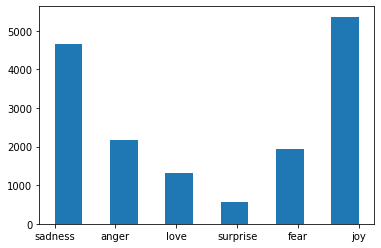

In [18]:
plt.hist(labels , bins = 11)
plt.show

there is inbalance in our classes but here we are going to continue with out doing any thing in this regard

In [19]:
class_to_index = dict((c , i) for i , c in enumerate(classes))
index_to_class = dict((i , c) for c , i in class_to_index.items())

In [20]:
print(class_to_index)

{'surprise': 0, 'joy': 1, 'sadness': 2, 'anger': 3, 'fear': 4, 'love': 5}


In [21]:
print(index_to_class)

{0: 'surprise', 1: 'joy', 2: 'sadness', 3: 'anger', 4: 'fear', 5: 'love'}


In [22]:
names_to_ids = lambda labels : np.array([class_to_index.get(x) for x in labels])

In [23]:
train_labels = names_to_ids(labels)
train_labels[0]

2

#building the model

In [24]:
model = tf.keras.models.Sequential([
                           tf.keras.layers.Embedding(10000 , 16 , input_length = maxlen),
                           tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20 , return_sequences=True)),
                           tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
                           tf.keras.layers.Dense(6 , activation='softmax')
])

model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 16)            160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 40)            5920      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 40)                9760      
_________________________________________________________________
dense (Dense)                (None, 6)                 246       
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


#training the model

### preparing the validation data

In [26]:
val_tweets , V_labels = get_tweet(val)
val_padded = get_sequences(tokenizer , val_tweets)
val_labels = names_to_ids(V_labels)

In [27]:
val_tweets[0] , val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 2)

In [28]:
h = model.fit(padded_train_seq , train_labels ,
              validation_data=(val_padded , val_labels),
              epochs = 20,
              callbacks = [
                           tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy' , patience=2)
              ])

Epoch 1/20
500/500 [==============================] - 43s 17ms/step - loss: 1.5555 - accuracy: 0.3326 - val_loss: 1.1463 - val_accuracy: 0.5510
Epoch 2/20
500/500 [==============================] - 7s 14ms/step - loss: 0.8761 - accuracy: 0.6493 - val_loss: 0.5993 - val_accuracy: 0.8070
Epoch 3/20
500/500 [==============================] - 7s 14ms/step - loss: 0.4158 - accuracy: 0.8624 - val_loss: 0.5000 - val_accuracy: 0.8375
Epoch 4/20
500/500 [==============================] - 7s 14ms/step - loss: 0.2708 - accuracy: 0.9104 - val_loss: 0.4379 - val_accuracy: 0.8690
Epoch 5/20
500/500 [==============================] - 7s 14ms/step - loss: 0.1845 - accuracy: 0.9431 - val_loss: 0.4132 - val_accuracy: 0.8785
Epoch 6/20
500/500 [==============================] - 7s 14ms/step - loss: 0.1315 - accuracy: 0.9594 - val_loss: 0.3938 - val_accuracy: 0.8815
Epoch 7/20
500/500 [==============================] - 7s 14ms/step - loss: 0.1079 - accuracy: 0.9674 - val_loss: 0.3976 - val_accuracy: 0.885

# evaluating the model

In [29]:

def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()


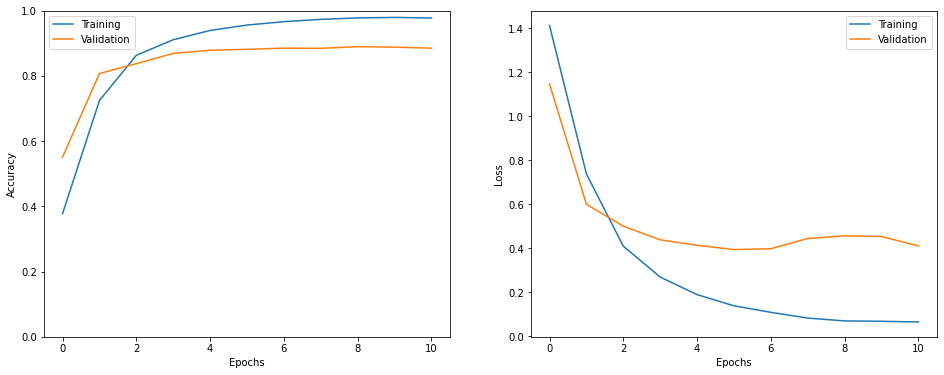

In [30]:
show_history(h)

In [32]:
test_tweets , test_labels = get_tweet(test)
padded_test_tweets = get_sequences(tokenizer , test_tweets)
test_labels = names_to_ids(test_labels)

In [33]:
_  = model.evaluate(padded_test_tweets , test_labels)

63/63 [==============================] - 0s 7ms/step - loss: 0.4077 - accuracy: 0.8815


In [84]:
i = random.randint(0 , len(test_labels)-1)

print('sentence : ' , test_tweets[i])
print('emotion : ' , index_to_class[test_labels[i]])

p = model.predict(np.expand_dims(padded_test_tweets[i] , axis=0))[0]
pred_class = index_to_class[np.argmax(p)]
print('prediction : ' , pred_class)

sentence :  i dont know how to deal with this i feel like its becoming apart if who i am im afraid that im going to associate it with regular things so that i will never forget it
emotion :  fear
prediction :  fear


In [83]:
preds = model.predict_classes(padded_test_tweets)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


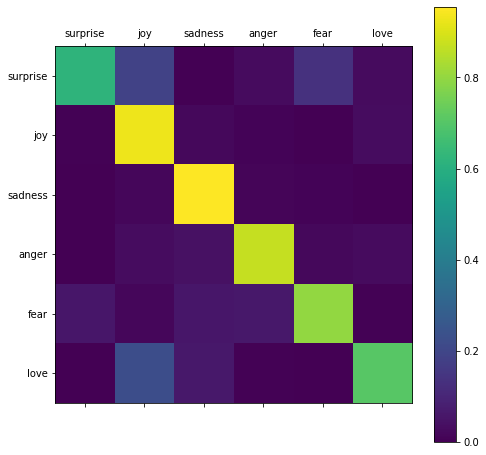

In [40]:
show_confusion_matrix(preds , test_labels , list(classes))

###### it is obvious that there are misclassification in 'love' and 'suprise' emotions

In [ ]:

# twts = [my_tweet , my_tweet_1]

# def prepare_and_pred(tweet):
#   pad = get_sequences(tokenizer,tweet)
#   pred = model.predict(pad)[0]
#   pred_class = index_to_class[np.argmax(pred)]
#   print(pred_class)
